# Collecting Pipeline Data/Statistics

The purpose of this notebook is to collect statistics on the postfiltering values of stars which are known to be dim hpms and large datasets from DES. These statistics will help inform how much we should constrain and filter in the pipeline (parameter tweaking).

In [1]:
# Dask puts out more advisory logging that we care for.
# It takes some doing to quiet all of it, but this recipe works.
import dask
import logging
import dask_jobqueue
from dask.dataframe.utils import make_meta
from dask.distributed import Client

dask.config.set({"logging.distributed": "critical"})

# This also has to be done, for the above to be effective
logger = logging.getLogger("distributed")
logger.setLevel(logging.CRITICAL)

import warnings

# Finally, suppress the specific warning about Dask dashboard port usage
warnings.filterwarnings("ignore", message="Port 8787 is already in use.")

from pathlib import Path

import numpy as np
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt
import time

from hats import read_hats

import lsdb

from catalog_filtering import bandFilterLenient, contains_PM
import hpms_pipeline as hpms

print("Imported libraries.")

Imported libraries.


In [31]:
bandList = ['G','R','I','Z','Y']
class_star = None
spread_model = 0.05
magnitude_error = 0.05
check_flags = True
mag = 19
query_string = bandFilterLenient(bandList,classStar=class_star,spreadModel=spread_model,magError=magnitude_error,flag=check_flags,mag=mag)
des_cols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)
k = 2
max_obj_deviation = 0.2
des_id_col = 'COADD_OBJECT_ID_1'
mag_cols = [f'WAVG_MAG_PSF_{band}' for band in ['I']]
min_neighbors = 4
max_neighbor_dist = 24
xmatch_max_neighbors = 100
print("Defined globals.")

Defined globals.


### Pipeline stats on 2-Degree conesearch near HPMS

In [8]:
BENCHMARK_CATALOG_DIR = Path("../../../catalogs/benchmark_catalogs")
CATALOG_NAME = "2.306965202564744e+18"
CATALOG_MC_NAME = "2306965202564744e18_25_arcsec_mc"
CATALOG_DIR = BENCHMARK_CATALOG_DIR / CATALOG_NAME
CATALOG_MC_DIR = BENCHMARK_CATALOG_DIR / CATALOG_MC_NAME

two_deg_catalog = lsdb.read_hats(CATALOG_DIR, margin_cache=CATALOG_MC_DIR)
two_deg_catalog

,CLASS_STAR_G,CLASS_STAR_R,CLASS_STAR_I,CLASS_STAR_Z,CLASS_STAR_Y,FLAGS_G,FLAGS_R,FLAGS_I,FLAGS_Z,FLAGS_Y,RA,DEC,COADD_OBJECT_ID,SPREAD_MODEL_G,SPREAD_MODEL_R,SPREAD_MODEL_I,SPREAD_MODEL_Z,SPREAD_MODEL_Y,WAVG_MAG_PSF_G,WAVG_MAG_PSF_R,WAVG_MAG_PSF_I,WAVG_MAG_PSF_Z,WAVG_MAG_PSF_Y,WAVG_MAGERR_PSF_G,WAVG_MAGERR_PSF_R,WAVG_MAGERR_PSF_I,WAVG_MAGERR_PSF_Z,WAVG_MAGERR_PSF_Y,NEPOCHS_G,NEPOCHS_R,NEPOCHS_I,NEPOCHS_Z,NEPOCHS_Y
npartitions=10,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 5, Pixel: 4096",double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int32[pyarrow],int32[pyarrow],int32[pyarrow],int32[pyarrow],int32[pyarrow]
"Order: 5, Pixel: 4097",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 8875",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 8878",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [9]:
import importlib
importlib.reload(hpms)

<module 'hpms_pipeline' from '/ocean/projects/phy210048p/jpassos/astrophysics/Jupyter Notebooks/kth_star_pipeline/hpms_pipeline.py'>

In [40]:
from dask.distributed import performance_report

original_size = len(two_deg_catalog)
subset=two_deg_catalog.cone_search(ra=1.383284152,dec=-37.36774403, radius_arcsec=1200)

print(f"Length of original catalog: {original_size}")
# print(f"Length of subset: {len(subset)}")
start_wall = time.time()

with Client(threads_per_worker=1, memory_limit='16GB', n_workers=16), performance_report(filename='dask-report-9.html'):
    two_deg_results = hpms.execute_pipeline(subset, query_string, xmatch_max_neighbors,
                                            max_neighbor_dist, min_neighbors, k,
                                            max_obj_deviation, des_id_col, mag_cols).to_hats(catalog_name='one_third_deg_cs_results', base_catalog_path = Path('./'), overwrite=True)
wall_time = time.time() - start_wall
print("Wall time: ", wall_time)
filtered_size = len(two_deg_results)
print(f"Length of final catalog: {filtered_size}")

Length of original catalog: 1567489


OSError: [Errno 22] Invalid argument: '.'

In [35]:
print(list(two_deg_results.columns))

['COADD_OBJECT_ID_1', 'CLASS_STAR_G_2', 'CLASS_STAR_R_2', 'CLASS_STAR_I_2', 'CLASS_STAR_Z_2', 'CLASS_STAR_Y_2', 'FLAGS_G_2', 'FLAGS_R_2', 'FLAGS_I_2', 'FLAGS_Z_2', 'FLAGS_Y_2', 'RA_2', 'DEC_2', 'COADD_OBJECT_ID_2', 'SPREAD_MODEL_G_2', 'SPREAD_MODEL_R_2', 'SPREAD_MODEL_I_2', 'SPREAD_MODEL_Z_2', 'SPREAD_MODEL_Y_2', 'WAVG_MAG_PSF_G_2', 'WAVG_MAG_PSF_R_2', 'WAVG_MAG_PSF_I_2', 'WAVG_MAG_PSF_Z_2', 'WAVG_MAG_PSF_Y_2', 'WAVG_MAGERR_PSF_G_2', 'WAVG_MAGERR_PSF_R_2', 'WAVG_MAGERR_PSF_I_2', 'WAVG_MAGERR_PSF_Z_2', 'WAVG_MAGERR_PSF_Y_2', 'NEPOCHS_G_2', 'NEPOCHS_R_2', 'NEPOCHS_I_2', 'NEPOCHS_Z_2', 'NEPOCHS_Y_2', 'kth_min_deviation', 'max_obj_distance', 'max_mag_diff']


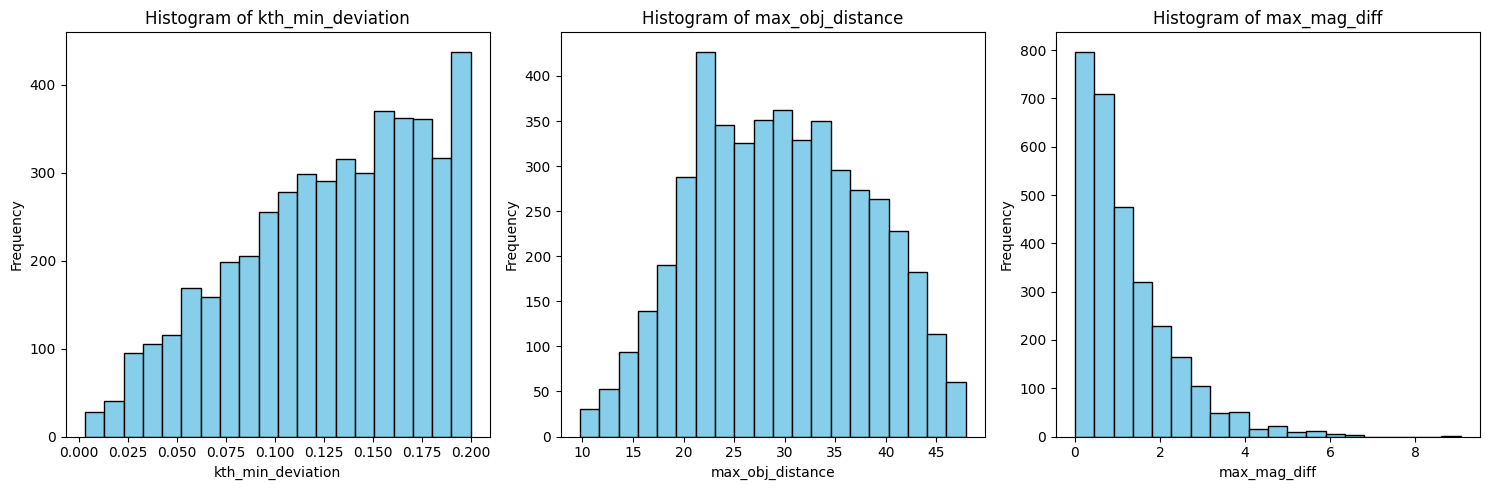

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

columns = ['kth_min_deviation', 'max_obj_distance', 'max_mag_diff']

for ax, col in zip(axes, columns):
    ax.hist(two_deg_results[col], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
missed_val = -99.0
computed_subset = subset.compute()

with Client(threads_per_worker=1, memory_limit='16GB', n_workers=16), performance_report(filename='dask-report-missed-detections.html'):
    missed_detections = subset.map_partitions(hpms.num_missed_detections, 
                                             ['WAVG_MAG_PSF_G', 'WAVG_MAG_PSF_R', 
                                              'WAVG_MAG_PSF_I', 'WAVG_MAG_PSF_Z', 
                                              'WAVG_MAG_PSF_Y'], missed_val).compute()

missed_g = (computed_subset['WAVG_MAG_PSF_G'] == missed_val).to_numpy().sum()
missed_r = (computed_subset['WAVG_MAG_PSF_R'] == missed_val).to_numpy().sum()
missed_i = (computed_subset['WAVG_MAG_PSF_I'] == missed_val).to_numpy().sum()
missed_z = (computed_subset['WAVG_MAG_PSF_Z'] == missed_val).to_numpy().sum()
missed_y = (computed_subset['WAVG_MAG_PSF_Y'] == missed_val).to_numpy().sum()


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/lsdb/catalog/dataset/healpix_dataset.py:534: RuntimeWarning: output of the function must be a DataFrame to generate an LSDB `Catalog`. `map_partitions` will return a dask object instead of a Catalog.
  warnings.warn(


In [16]:
missed_detections

_healpix_29
1153464661165131512    0
1153466129614435957    5
                      ..
1154612699815914664    4
1154612700106214671    0
Name: n_missed_detections, Length: 44504, dtype: int64

G band: 0.5111675355024268% missed detection
R band: 0.41710857451015637% missed detection
I band: 0.5198633830666907% missed detection
Z band: 0.6211351788603272% missed detection
Y band: 0.8440589609922704% missed detection


/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/dask/dataframe/dask_expr/_collection.py:1430: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting int32[pyarrow] to object dtype.
  warnings.warn(
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/dask/dataframe/dask_expr/_collection.py:1430: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting int32[pyarrow] to object dtype.
  warnings.warn(
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/dask/dataframe/dask_expr/_collection.py:1430: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting int32[pyarrow] to object dtype.
  warnings.warn(
/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/dask/dataframe/dask_expr/_collection.py:1430

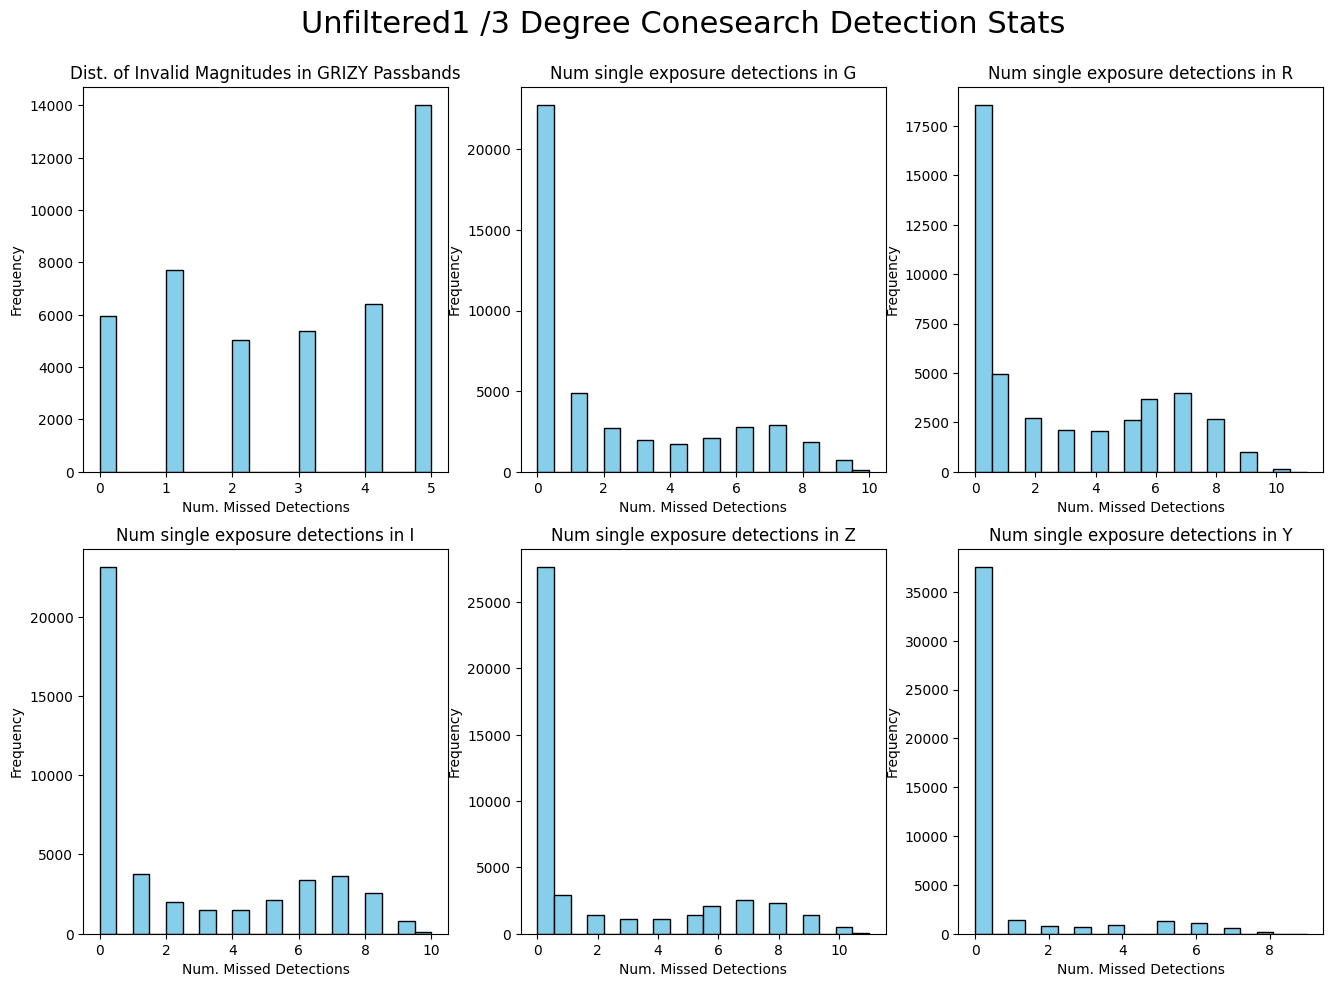

In [33]:
print(f"G band: {missed_g/len(computed_subset)}% missed detection")
print(f"R band: {missed_r/len(computed_subset)}% missed detection")
print(f"I band: {missed_i/len(computed_subset)}% missed detection")
print(f"Z band: {missed_z/len(computed_subset)}% missed detection")
print(f"Y band: {missed_y/len(computed_subset)}% missed detection")

fig, axes = plt.subplots(2, 3, figsize=(16,11))
fig.suptitle('Unfiltered1 /3 Degree Conesearch Detection Stats', size=22,y=0.95)

nepochs_cols = ['NEPOCHS_G', 'NEPOCHS_R', 'NEPOCHS_I', 'NEPOCHS_Z', 'NEPOCHS_Y'] 
columns = [missed_detections] + [subset[col] for col in nepochs_cols]
names = ['Dist. of Invalid Magnitudes in GRIZY Passbands'] + [f'Num single exposure detections in {band}' for band in ['G','R','I','Z','Y']]

for ax, col, name in zip(axes.flatten(), columns, names):
    ax.hist(col, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Num. Missed Detections')
    ax.set_ylabel('Frequency')

### Pipeline Stats on Found HPMS

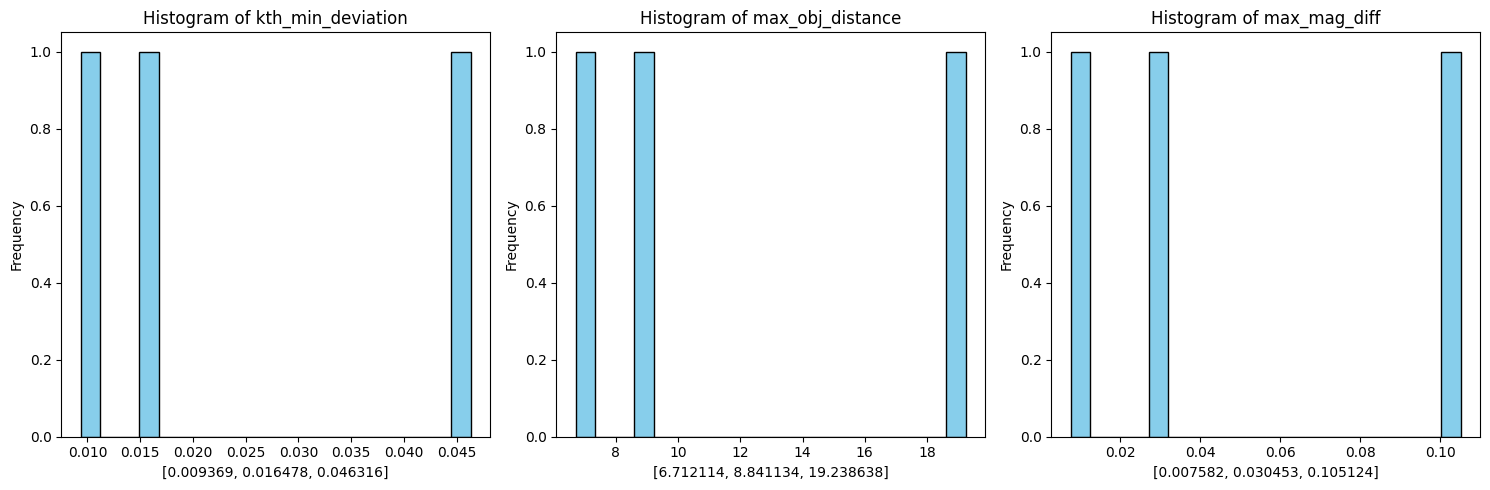

In [8]:
#These were manually obtained from runs in test_execute_pipeline.ipynb

kth_min_deviation = [0.009369,0.016478,0.0463160]
max_obj_distance = [6.712114,8.841134,19.238638]
max_mag_diff = [.007582, 0.030453, 0.105124]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

columns = [kth_min_deviation, max_obj_distance, max_mag_diff]
names = ['kth_min_deviation', 'max_obj_distance', 'max_mag_diff']

for ax, col, name in zip(axes, columns, names):
    ax.hist(col, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()